# Personal Information
Name: **Yanchao MURONG**

StudentID: **14090759**

Email: [**yanchao.murong@student.uva.nl**](yanchao.murong@student.uva.nl)

Submitted on: **25.03.2024**

# Data Context

The purpose of this EDA is to compare the syntactical structure of human questions from the BSARD dataset and synthetic questions generated by MT5.

BSARD dataset (dfQ_human):

The Belgian Statutory Article Retrieval Dataset (BSARD) is a dataset created for the task of statutory article retrieval (SAR). The corpus consisted of 22,633 law articles extracted from 32 publicly available Belgian codes. The questions were collected from Droits Quotidiens, an organization that clarifies the law for laypeople, and were carefully labeled with the ids of the corresponding relevant law articles from the corpus. The dataset was split into training/test sets with 886 and 222 questions, respectively. The dataset has a wide range of legal topics, with around 85% of the questions being about family, housing, money, or justice. The questions might have one or several relevant legal articles, and 75% of the questions have less than five relevant articles. Overall, out of the 22,633 articles, only 1612 are referred to as relevant to at least one question in the dataset, and around 80% of these articles come from either the Civil Code, Judicial Code, Criminal Investigation Code, or Penal Code.

Synthetic Dataset 1 (dfQ_syn1):
Synthetic questions data generated by the model mT5 on my own. We have generated 1 question for each legal article from BSARD Dataset (due to computation limit). 


Synthetic Dataset 2 (dfQ_syn2):
Synthetic questions data generated by author of BSARD Dataset. 5 question for each legal article from BSARD Dataset are generated. 

# Data Description

**Present here the results of your exploratory data analysis. Note that there is no need to have a "story line" - it is more important that you show your understanding of the data and the methods that you will be using in your experiments (i.e. your methodology).**

**As an example, you could show data, label, or group balances, skewness, and basic characterizations of the data. Information about data frequency and distributions as well as results from reduction mechanisms such as PCA could be useful. Furthermore, indicate outliers and how/why you are taking them out of your samples, if you do so.**

**The idea is, that you conduct this analysis to a) understand the data better but b) also to verify the shapes of the distributions and whether they meet the assumptions of the methods that you will attempt to use. Finally, make good use of images, diagrams, and tables to showcase what information you have extracted from your data.**

As you can see, you are in a jupyter notebook environment here. This means that you should focus little on writing text and more on actually exploring your data. If you need to, you can use the amsmath environment in-line: $e=mc^2$ or also in separate equations such as here:

\begin{equation}
    e=mc^2 \mathrm{\space where \space} e,m,c\in \mathbb{R}
\end{equation}

In [10]:
# Imports
import os
import numpy as np
import pandas as pd
from parallel_pandas import ParallelPandas
import matplotlib.pyplot as plt
import spacy
from spacy.matcher import Matcher
from tqdm import tqdm
ParallelPandas.initialize(disable_pr_bar=False)
tqdm.pandas(desc='Processing text')
nlp = spacy.load("fr_core_news_sm")

### Data Loading

In [2]:
# Load your data here
dfQ_train = pd.read_csv("./data/questions_fr_train.csv")
dfQ_test = pd.read_csv("./data/questions_fr_test.csv")

dfQ_human = pd.concat([dfQ_train, dfQ_test])
dfQ_syn1 = pd.read_json("./data/qgen-queries.jsonl", lines=True)
dfQ_syn2 = pd.read_csv("./data/questions_synthetic.csv")

dfQ_mmarco = pd.read_csv("./data/mmarco/french_queries.train.tsv", sep='\t', header=None, names=["id", "question"])

### Analysis 1: Question Size

In [3]:
# Count the number of questions in each DataFrame
counts = [len(df) for df in [dfQ_human, dfQ_syn1, dfQ_syn2]]

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'DataFrame': ['dfQ_human', 'dfQ_syn1', 'dfQ_syn2'],
    'Number of Questions': counts
})
summary_df

,DataFrame,Number of Questions
0,dfQ_human,1108
1,dfQ_syn1,22633
2,dfQ_syn2,113165


([0, 1, 2],
 [Text(0, 0, 'dfQ_human'), Text(1, 0, 'dfQ_syn1'), Text(2, 0, 'dfQ_syn2')])

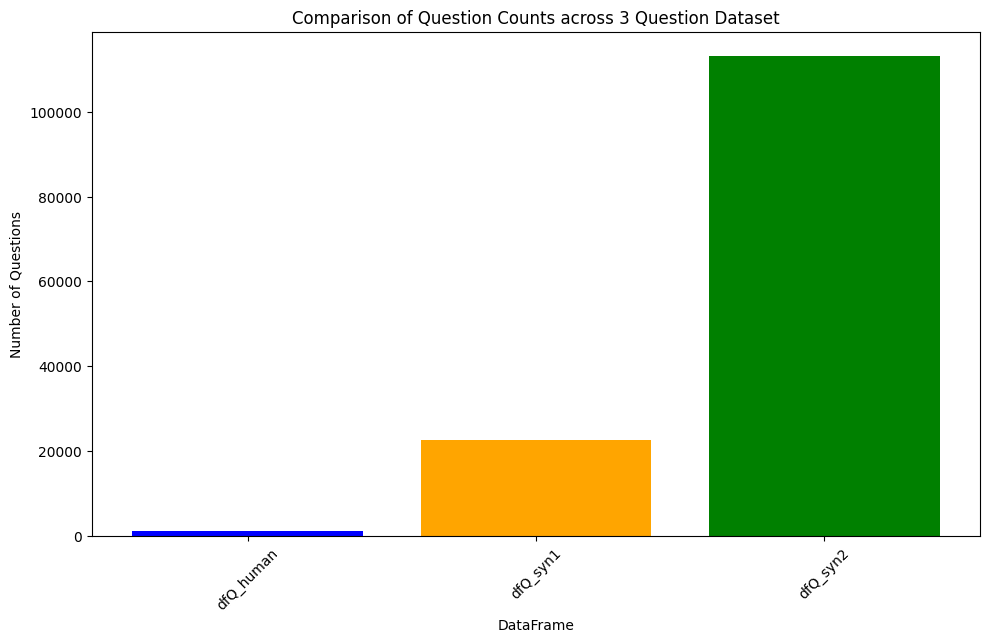

In [4]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(summary_df['DataFrame'], summary_df['Number of Questions'], color=['blue', 'orange', 'green'])
plt.title('Comparison of Question Counts across 3 Question Dataset')
plt.xlabel('DataFrame')
plt.ylabel('Number of Questions')
plt.tight_layout()
plt.savefig('Comparison of Question Counts across 3 Question Dataset.pdf')
plt.xticks(rotation=45)

### Analysis 2: Question Length

In [5]:
# Calculate the length of each question
dfQ_human['Length'] = dfQ_human['question'].apply(len)
dfQ_syn1['Length'] = dfQ_syn1['text'].apply(len)
dfQ_syn2['Length'] = dfQ_syn2['question'].apply(len)

# Compute the average length of questions in each DataFrame
avg_lengths = [df['Length'].mean() for df in [dfQ_human, dfQ_syn1, dfQ_syn2]]

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'DataFrame': ['dfQ_human', 'dfQ_syn1', 'dfQ_syn2'],
    'Average Question Length': avg_lengths
})

summary_df

,DataFrame,Average Question Length
0,dfQ_human,88.252708
1,dfQ_syn1,54.395308
2,dfQ_syn2,54.762665


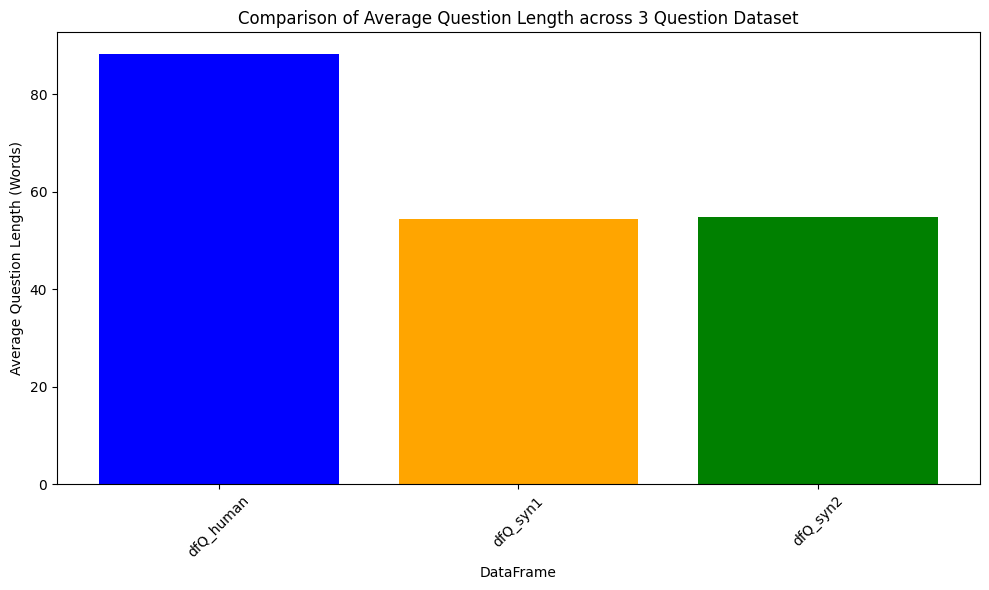

In [6]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(summary_df['DataFrame'], summary_df['Average Question Length'], color=['blue', 'orange', 'green'])
plt.title('Comparison of Average Question Length across 3 Question Dataset')
plt.xlabel('DataFrame')
plt.ylabel('Average Question Length (Words)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Comparison of Average Question Length across DataFrames.pdf')
plt.show()

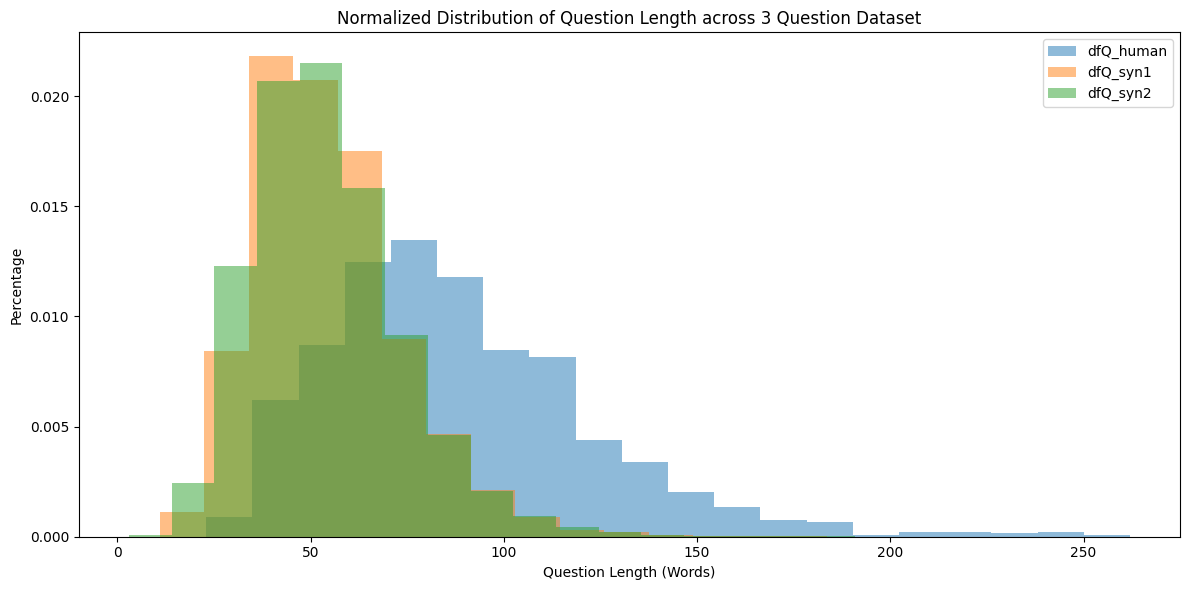

In [7]:
# Plotting
plt.figure(figsize=(12, 6))

# Histograms for each DataFrame
plt.hist(dfQ_human['Length'], alpha=0.5, label='dfQ_human', bins=20, density=True)
plt.hist(dfQ_syn1['Length'], alpha=0.5, label='dfQ_syn1', bins=20, density=True)
plt.hist(dfQ_syn2['Length'], alpha=0.5, label='dfQ_syn2', bins=20, density=True)

plt.title('Normalized Distribution of Question Length across 3 Question Dataset')
plt.xlabel('Question Length (Words)')
plt.ylabel('Percentage')
plt.legend()
plt.tight_layout()
plt.savefig('Normalized Distribution of Question Lengths.pdf')
plt.show()

### Analysis 3: Number of Sentences in Question


In [12]:
class TextPreprocessor():
    def __init__(self, spacy_model="fr_core_news_sm"):
        self.nlp = spacy.load(spacy_model)

    def preprocess(self, series, sentences=False):
        return (series.progress_apply(
            lambda text: self.preprocess_text(text, sentences)))

    def preprocess_text(self, text, split_sentences):
        doc = self.nlp(text)
        if split_sentences:
            return list(doc.sents)
        else:
            text = self._get_text(doc)
        return text

    def _get_text(self, doc):
        return ' '.join([t.text for t in doc])


processor = TextPreprocessor()

dfQ_human['NB_SENTENCES'] = processor.preprocess(dfQ_human["question"], sentences=True).apply(len)
dfQ_syn1['NB_SENTENCES'] = processor.preprocess(dfQ_syn1["text"], sentences=True).apply(len)
dfQ_syn2['NB_SENTENCES'] = processor.preprocess(dfQ_syn2["question"], sentences=True).apply(len)


Processing text: 100%|██████████| 113165/113165 [06:04<00:00, 310.05it/s]


In [13]:
# Compute the average length of questions in each DataFrame
avg_lengths = [df['NB_SENTENCES'].mean() for df in [dfQ_human, dfQ_syn1, dfQ_syn2]]

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'DataFrame': ['dfQ_human', 'dfQ_syn1', 'dfQ_syn2'],
    'Average Number of Sentences in Question': avg_lengths
})

summary_df

,DataFrame,Average Number of Sentences in Question
0,dfQ_human,1.618231
1,dfQ_syn1,1.048867
2,dfQ_syn2,1.051562


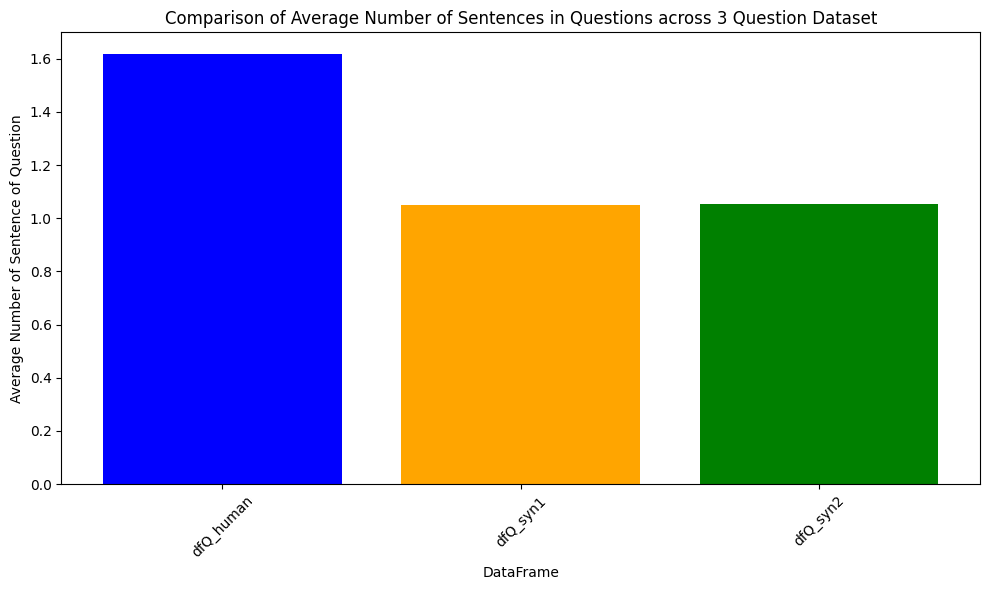

In [14]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(summary_df['DataFrame'], summary_df['Average Number of Sentences in Question'],
        color=['blue', 'orange', 'green'])
plt.title('Comparison of Average Number of Sentences in Questions across 3 Question Dataset')
plt.xlabel('DataFrame')
plt.ylabel('Average Number of Sentence of Question')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Comparison of Average Number of Sentence of Question across DataFrames.pdf')
plt.show()

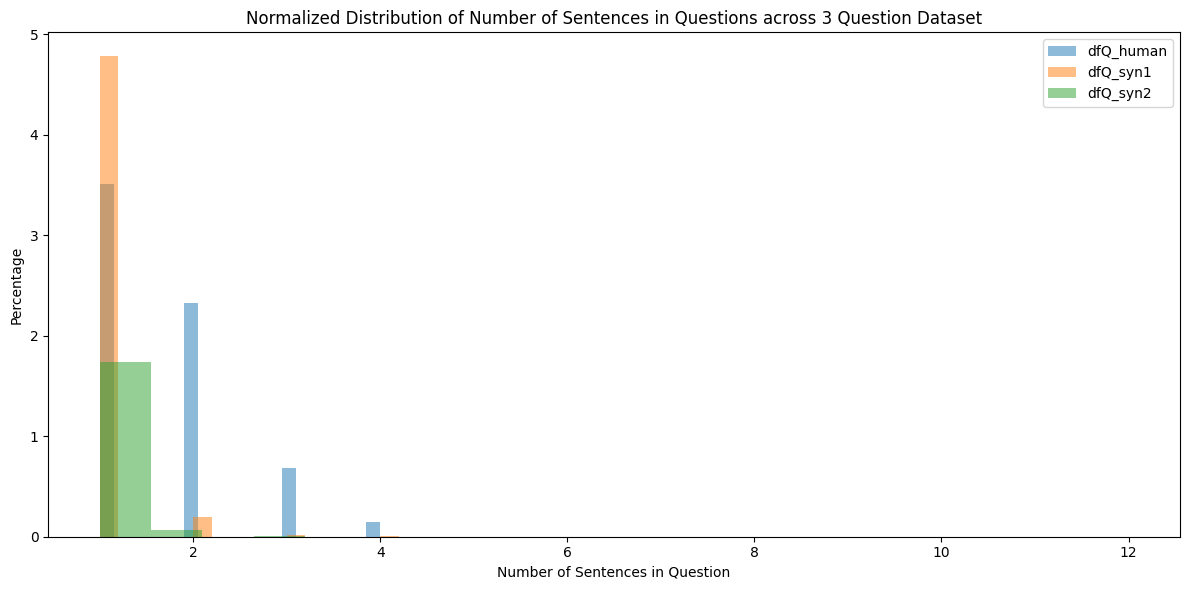

In [15]:
# Plotting
plt.figure(figsize=(12, 6))

# Histograms for each DataFrame
plt.hist(dfQ_human['NB_SENTENCES'], alpha=0.5, label='dfQ_human', bins=20, density=True)
plt.hist(dfQ_syn1['NB_SENTENCES'], alpha=0.5, label='dfQ_syn1', bins=20, density=True)
plt.hist(dfQ_syn2['NB_SENTENCES'], alpha=0.5, label='dfQ_syn2', bins=20, density=True)

plt.title('Normalized Distribution of Number of Sentences in Questions across 3 Question Dataset')
plt.xlabel('Number of Sentences in Question')
plt.ylabel('Percentage')
plt.legend()
plt.tight_layout()
plt.savefig('Normalized Distribution of Number of Sentences in Question.pdf')
plt.show()

### Analysis 4: Pos Tagging Distribution

In [16]:
# Function to count POS tags in a dataset
def count_pos_tags(series):
    tag_counts = {}
    for question in series:
        doc = nlp(question)
        for token in doc:
            tag = token.pos_
            tag_counts[tag] = tag_counts.get(tag, 0) + 1
    total_tags = sum(tag_counts.values())
    # Normalize counts to get density
    tag_counts = {tag: count / total_tags for tag, count in tag_counts.items()}
    return tag_counts

In [17]:
dfQ_human_pos_dist = count_pos_tags(dfQ_human["question"])
dfQ_syn1_pos_dist = count_pos_tags(dfQ_syn1["text"])
dfQ_syn2_pos_dist = count_pos_tags(dfQ_syn2["question"])

In [18]:
dfQ_mmarco_pos_dist = count_pos_tags(dfQ_mmarco["question"].sample(10000))

In [21]:
tag_counts_datasets = [dfQ_human_pos_dist, dfQ_syn1_pos_dist, dfQ_syn2_pos_dist, dfQ_mmarco_pos_dist]
# Convert to DataFrame for easier plotting
df_tags = pd.DataFrame(tag_counts_datasets).T
df_tags.columns = ['dfQ_human', 'dfQ_syn1', 'dfQ_syn2', 'dfQ_mmarco']
df_tags = df_tags.fillna(0)  # Fill missing values with 0
df_tags

,dfQ_human,dfQ_syn1,dfQ_syn2,dfQ_mmarco
PRON,0.116705,0.072453,8.325543e-02,0.089491
AUX,0.041390,0.067481,6.253351e-02,0.058349
ADJ,0.058172,0.084133,7.295272e-02,0.091868
PROPN,0.025637,0.005653,3.892074e-03,0.019974
PUNCT,0.105380,0.008878,8.606982e-03,0.012741
CCONJ,0.019408,0.008112,6.217670e-03,0.007710
VERB,0.117786,0.069744,8.279123e-02,0.087303
ADP,0.135753,0.179172,1.779086e-01,0.155097
DET,0.117992,0.172053,1.652429e-01,0.145047
NOUN,0.194698,0.281459,2.805816e-01,0.262700


IndexError: index 4 is out of bounds for axis 0 with size 4

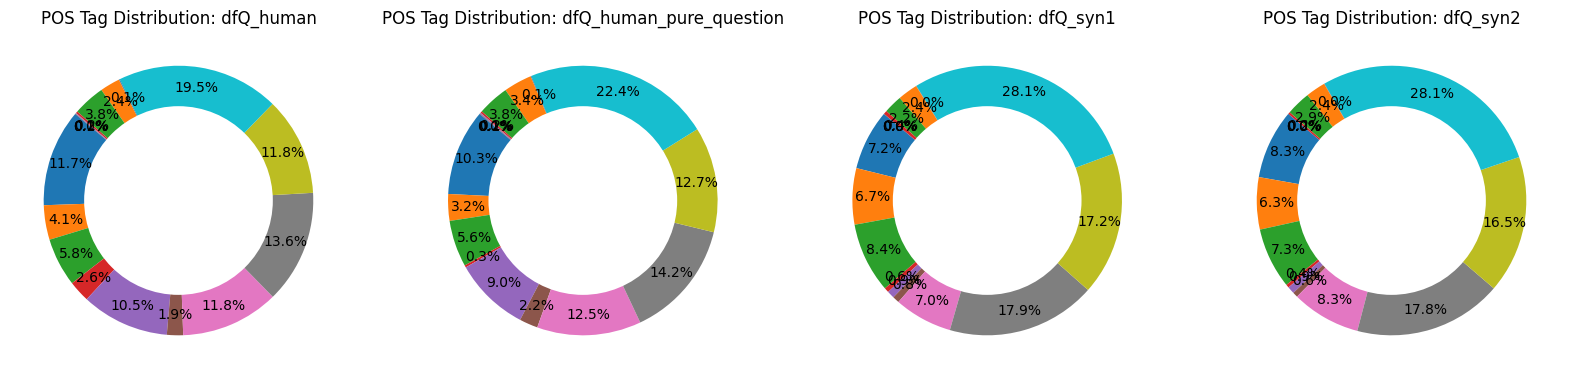

In [28]:
# Function to plot pie chart for each dataset
def plot_pie_chart(data, title, ax):
    data.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=140, pctdistance=0.85, labels=None)
    ax.set_ylabel('')  # Remove the y-label as it's not needed for pie charts
    ax.set_title(title)
    # Draw a circle at the center to make it a donut chart
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax.add_artist(centre_circle)


# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 7))

# Plotting pie charts for each dataset
for i, column in enumerate(df_tags.columns):
    plot_pie_chart(df_tags[column], f'POS Tag Distribution: {column}', axes[i])

plt.tight_layout()
plt.savefig('POS Tag Distribution.pdf')
plt.show()

In [25]:
# Extract Interrogative phrase from human questions
dfQ_human_sentences = processor.preprocess(dfQ_human["question"], sentences=True)
dfQ_human_questions = dfQ_human_sentences.apply(
    lambda text: [sent.text.lower() for sent in text if "?" in sent.text.lower()][0]
)
dfQ_human_pure_question_pos_dist = count_pos_tags(dfQ_human_questions)

Processing text: 100%|██████████| 1108/1108 [00:03<00:00, 300.77it/s]


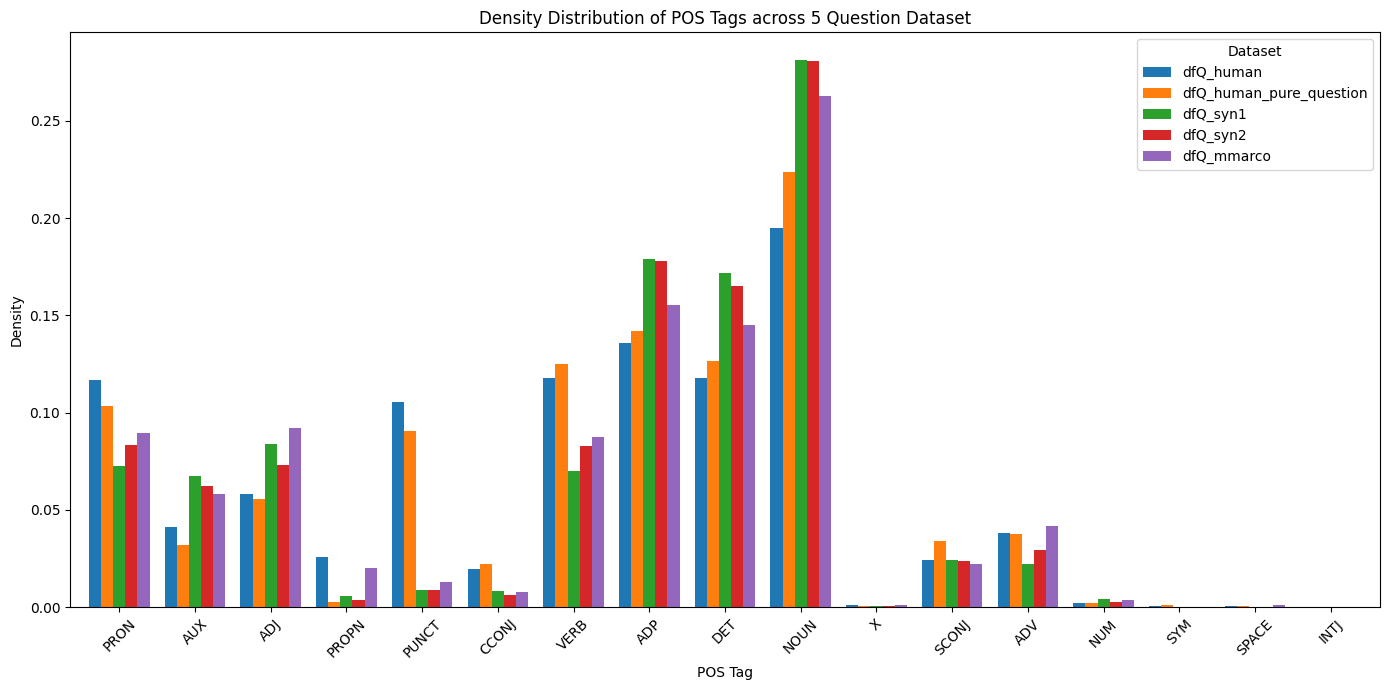

In [27]:
tag_counts_datasets = [dfQ_human_pos_dist, dfQ_human_pure_question_pos_dist, dfQ_syn1_pos_dist, dfQ_syn2_pos_dist, dfQ_mmarco_pos_dist]
# Convert to DataFrame for easier plotting
df_tags = pd.DataFrame(tag_counts_datasets).T
df_tags.columns = ['dfQ_human', 'dfQ_human_pure_question', 'dfQ_syn1', 'dfQ_syn2', 'dfQ_mmarco']
df_tags = df_tags.fillna(0)  # Fill missing values with 0

# Plot the density distribution of POS tags
df_tags.plot(kind='bar', figsize=(14, 7), width=0.8)
plt.title('Density Distribution of POS Tags across 5 Question Dataset')
plt.xlabel('POS Tag')
plt.ylabel('Density')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.savefig('Density Distribution of POS Tags Across Datasets.pdf')
plt.show()

### Analysis 5: Question Categories
* Yes/No
* What
* Which
* Where
* Why
* How

In [29]:
# Extract Interrogative phrase from human questions
dfQ_human_sentences = processor.preprocess(dfQ_human["question"], sentences=True)
dfQ_human_questions = dfQ_human_sentences.apply(
    lambda text: [sent.text.lower() for sent in text if "?" in sent.text.lower()][0]
)
dfQ_human_questions

Processing text: 100%|██████████| 1108/1108 [00:03<00:00, 299.69it/s]


0      puis-je refuser de faire des heures supplément...
1                      peut-on saisir tous mes revenus ?
2                       dois-je reconnaître mon enfant ?
3      pour quels logements le permis de location est...
4      suis-je payé pendant la procédure du trajet de...
                             ...                        
217    dois-je payer les dettes de mon cohabitant lég...
218                       a qui dois-je payer ma dette ?
219                          qui doit payer les loyers ?
220    est-ce que je peux signer plusieurs baux de co...
221    en tant que victime de violences conjugales, p...
Name: question, Length: 1108, dtype: object

In [32]:



def categorize_question(question):
    def is_yes_no_question(question):
        # Normalize the sentence to lowercase to simplify matching
        question = question.lower()

        # Define the beginnings of potential yes-no questions in French
        question_starters = [
            'suis-je', 'es-tu', 'est-il', 'sommes-nous', 'êtes-vous', 'sont-ils', 'sont-elles', 'est-elle',  # Être
            'ai-je', 'as-tu', 'a-t-il', 'avons-nous', 'avez-vous', 'ont-ils', 'ont-elles', 'a-t-on',  # Avoir
            'peux-tu', 'peut-il', 'pouvons-nous', 'pouvez-vous', 'peuvent-ils', 'puis-je', 'peut-on', 'peut-elle',
            # Pouvoir
            'dois-je', 'doit-il', 'devons-nous', 'devez-vous', 'doivent-ils', 'doit-on',  # Devoir
            'vais-je', 'vas-tu', 'va-t-il', 'allons-nous', 'allez-vous', 'vont-ils', 'va-t-on',  # Aller (future)
            'est-ce', 'faut-il', 't-il', 'est un', 'est une', 'est le', 'est la',
        ]

        return any(starter in question for starter in question_starters)

    def is_what_which_question(question):
        # Normalize the sentence to lowercase to simplify matching
        question = question.lower()

        # Define the beginnings of potential yes-no questions in French
        question_starters = [
            'que f', 'que d', 'que s', 'que c', 'que v', 'qu\'est', 'quels ', 'quelles ', 'quelle ', 'quel ',
            'combien ',
            'à quoi', 'c\'est quoi', 'de quoi'
        ]

        # Check if the sentence starts with any of the question starters
        return any(starter in question for starter in question_starters)

    def is_when_question(question):
        # Normalize the sentence to lowercase to simplify matching
        question = question.lower()

        # Define the beginnings of potential yes-no questions in French
        question_starters = [
            'quand', 'quel moment'
        ]

        # Check if the sentence starts with any of the question starters
        return any(starter in question for starter in question_starters)

    def is_where_question(question):
        # Normalize the sentence to lowercase to simplify matching
        question = question.lower()

        # Define the beginnings of potential yes-no questions in French
        question_starters = [
            'où'
        ]

        # Check if the sentence starts with any of the question starters
        return any(starter in question for starter in question_starters)

    def is_how_question(question):
        # Normalize the sentence to lowercase to simplify matching
        question = question.lower()

        # Define the beginnings of potential yes-no questions in French
        question_starters = [
            'comment'
        ]

        # Check if the sentence starts with any of the question starters
        return any(starter in question for starter in question_starters)

    def is_who_question(question):
        # Normalize the sentence to lowercase to simplify matching
        question = question.lower()

        # Define the beginnings of potential yes-no questions in French
        question_starters = [
            'qui '
        ]

        # Check if the sentence starts with any of the question starters
        return any(starter in question for starter in question_starters)

    def is_why_question(question):
        # Normalize the sentence to lowercase to simplify matching
        question = question.lower()

        # Define the beginnings of potential yes-no questions in French
        question_starters = [
            'pourquoi'
        ]

        # Check if the sentence starts with any of the question starters
        return any(starter in question for starter in question_starters)

    # Lowercase the question for standardization
    question = question.lower()

    if is_why_question(question):
        return "why"

    if is_how_question(question):
        return "how"

    if is_where_question(question):
        return "where"

    if is_when_question(question):
        return "when"

    if is_who_question(question):
        return "who"

    if is_what_which_question(question):
        # with open("what_questions.txt", "a") as f:
        #     f.write(question + "\n")
        return "what/which"

    if is_yes_no_question(question):
        # with open("yes_no_questions.txt", "a") as f:
        #     f.write(question + "\n")
        return "yes/no"

    with open("unknown_questions.txt", "a", encoding="utf-8") as f:
        f.write(question + "\n")

    return 'unknown'

In [33]:
with open("unknown_questions.txt", "a") as f:
    f.truncate(0)
with open("yes_no_questions.txt", "a") as f:
    f.truncate(0)
with open("what_questions.txt", "a") as f:
    f.truncate(0)
dfQ_human_questions_cat = dfQ_human_questions.p_apply(categorize_question).value_counts(normalize=True)

CATEGORIZE_QUESTION DONE:   0%|          | 0/1108 [00:00<?, ?it/s]

In [34]:
with open("unknown_questions.txt", "a") as f:
    f.truncate(0)
with open("yes_no_questions.txt", "a") as f:
    f.truncate(0)
with open("what_questions.txt", "a") as f:
    f.truncate(0)
dfQ_syn1_questions_cat = dfQ_syn1["text"].p_apply(categorize_question).value_counts(normalize=True)

CATEGORIZE_QUESTION DONE:   0%|          | 0/22633 [00:00<?, ?it/s]

In [35]:
dfQ_mmarco.columns

Index(['id', 'question'], dtype='object')

In [36]:
with open("unknown_questions.txt", "a") as f:
    f.truncate(0)
with open("yes_no_questions.txt", "a") as f:
    f.truncate(0)
with open("what_questions.txt", "a") as f:
    f.truncate(0)
dfQ_syn2_questions_cat = dfQ_syn2["question"].p_apply(categorize_question).value_counts(normalize=True)

CATEGORIZE_QUESTION DONE:   0%|          | 0/113165 [00:00<?, ?it/s]

In [37]:
with open("unknown_questions.txt", "a") as f:
    f.truncate(0)
with open("yes_no_questions.txt", "a") as f:
    f.truncate(0)
with open("what_questions.txt", "a") as f:
    f.truncate(0)
dfQ_mmarco_questions_cat = dfQ_mmarco["question"].p_apply(categorize_question).value_counts(normalize=True)

CATEGORIZE_QUESTION DONE:   0%|          | 0/808731 [00:00<?, ?it/s]

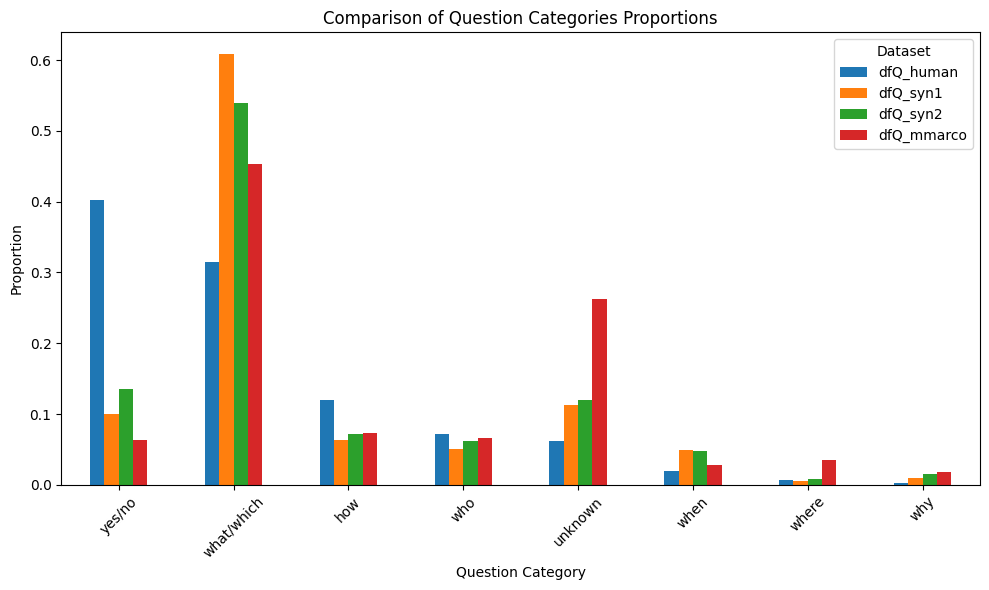

In [38]:
# Combine Series into a DataFrame
df = pd.concat([dfQ_human_questions_cat, dfQ_syn1_questions_cat, dfQ_syn2_questions_cat, dfQ_mmarco_questions_cat],
               axis=1)
df.columns = ['dfQ_human', 'dfQ_syn1', 'dfQ_syn2', 'dfQ_mmarco']

# Plot
df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Question Categories Proportions')
plt.xlabel('Question Category')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.savefig('Comparison of Question Categories Proportions.pdf')
plt.show()